In [1]:
# === colab configuration ===
# p.s. when training on colab, weights are saved on Drive (directory DSCAS/weights).
# p.p.s. skip this cell if running demo file locally!

! pip install torch-summary
! pip install ray
from google.colab import drive
import sys

# setting paths
repository_path = '/content/deep-seasonal-color-analysis-system/'
dataset_path = repository_path + 'headsegmentation_dataset_ccncsa/'
dataset_path_drive = '/content/drive/MyDrive/DSCAS/headsegmentation_dataset_ccncsa/'
weights_path = repository_path + 'models/weights/'
weights_path_drive = '/content/drive/MyDrive/DSCAS/weights/'
sys.path.insert(0, repository_path)

# cloning project repository and downloading dataset
drive.mount('/content/drive')
! test ! -d $repository_path && git clone https://github.com/mrcmich/deep-seasonal-color-analysis-system.git
! test ! -d $dataset_path && cp -R $dataset_path_drive $dataset_path
%cd $repository_path

# setting branch and pulling updates
branch = 'main__fastscnn_hyperparameters_tuning'
! git checkout $branch
! git pull origin $branch

executing_on_colab = True

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive
Cloning into 'deep-seasonal-color-analysis-system'...
remote: Enumerating objects: 642, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 642 (delta 27), reused 33 (delta 13), pack-reused 519
Receiving objects: 100% (642/642), 81.31 MiB | 38.78 MiB/s, done.
Resolving deltas: 100% (346/346), done.
/content/deep-seasonal-color-analysis-system
Branch 'main__fastscnn_hyperparameters_tuning' set up to track remote branch 'main__fastscnn_hyperparameters_tuning' from 'origin'.
Switched to a new branch 'main__fastscnn_hyperparameters_tuning'
From https://github.com/mrcmich/deep-seasonal-color-analysis-system
 * branch            main__fastscnn_hyperparameters_tuning -> FETCH_HEAD
Already up to date.


In [2]:
import torch
from torch import nn, optim
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from models import dataset, training_and_testing
from models.cloud.UNet import unet
from metrics_and_losses import metrics
from utils import segmentation_labels, custom_transforms
import matplotlib.pyplot as plt
from models.config import *

try:
  executing_on_colab
except NameError:
  executing_on_colab = False

In [3]:
# local configuration
if executing_on_colab is False:
  weights_path = 'models/weights/'
  dataset_path = ROOT_DIR + 'headsegmentation_dataset_ccncsa/'

In [4]:
# === defining transforms ===

tH, tW = 256, 256
diameter = 7
sigma_color = 50
sigma_space = 100
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225] # from ImageNet
horizontal_flip = custom_transforms.PartiallyDeterministicHorizontalFlip(p=0.5)
center_crop = custom_transforms.PartiallyDeterministicCenterCrop(p=0.5)

image_transform = T.Compose([
    T.Resize((tH, tW)), 
    custom_transforms.BilateralFilter(sigma_color, sigma_space, diameter), 
    T.Normalize(mean, std)])

target_transform = T.Compose([T.Resize((tH, tW))])

# fetching dataset
n_classes = len(segmentation_labels.labels)
img_paths, label_paths = dataset.get_paths(dataset_path, file_name='training.xml')
X_train, _, Y_train, _ = train_test_split(img_paths, label_paths, test_size=0.20, random_state=99, shuffle=True)
train_dataset = dataset.MyDataset(X_train, Y_train, image_transform, target_transform)

# setting up hyperparameters for training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_epochs = 10
batch_size = 32
loss_fn = nn.CrossEntropyLoss()
score_fn = metrics.batch_mIoU
learning_rate = 0.01

Device: cuda.
--- Epoch 1/10 ---
average_train_loss: 0.7051170030210772, average_train_score: 0.360393226146698
average_val_loss: 0.6664246178808666, average_val_score: 0.36372774839401245
--- Epoch 2/10 ---
average_train_loss: 0.5437945299848193, average_train_score: 0.39407360553741455
average_val_loss: 0.5360232709892212, average_val_score: 0.3781489431858063
--- Epoch 3/10 ---
average_train_loss: 0.44550186013564086, average_train_score: 0.41232773661613464
average_val_loss: 0.4749339520931244, average_val_score: 0.3872925937175751
--- Epoch 4/10 ---
average_train_loss: 0.36690621353961805, average_train_score: 0.42112502455711365
average_val_loss: 0.39777127523270867, average_val_score: 0.40007948875427246
--- Epoch 5/10 ---
average_train_loss: 0.2981757186247073, average_train_score: 0.4436918795108795
average_val_loss: 0.3190282815032535, average_val_score: 0.42238369584083557
--- Epoch 6/10 ---
average_train_loss: 0.2493111862246467, average_train_score: 0.4757814407348633
aver

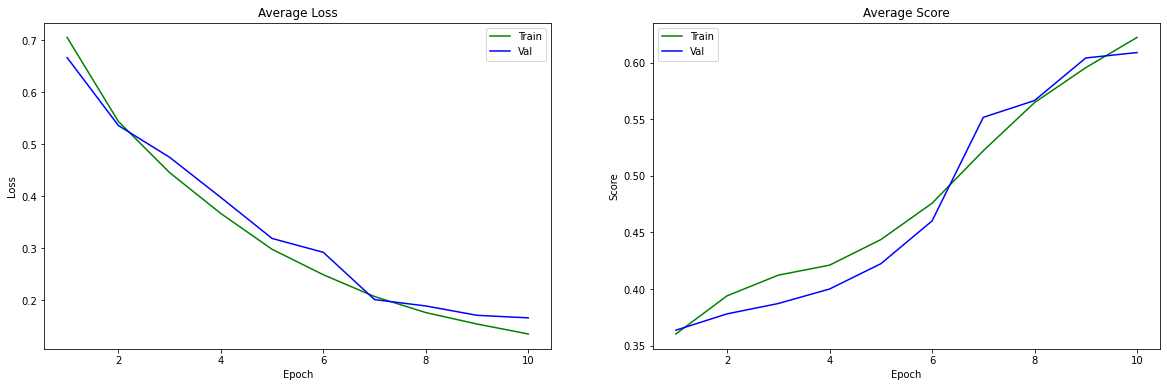

In [5]:
# === training without augmentation ===

model = unet.UNet(out_channels=n_classes)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

results = training_and_testing.train_model(
    device, model, train_dataset, batch_size, n_epochs, score_fn, loss_fn, optimizer, 
    lr_scheduler=None, evaluate=True, verbose=True)

training_and_testing.plot_training_results(results, plotsize=(20, 6))

Device: cuda.
--- Epoch 1/10 ---
average_train_loss: 0.7655416044414552, average_train_score: 0.3483579158782959
average_val_loss: 0.6736008193757799, average_val_score: 0.36696988344192505
--- Epoch 2/10 ---
average_train_loss: 0.6153255892105591, average_train_score: 0.3781663477420807
average_val_loss: 0.7606537067700946, average_val_score: 0.3512189984321594
--- Epoch 3/10 ---
average_train_loss: 0.534150804125006, average_train_score: 0.40259766578674316
average_val_loss: 0.5250173286786155, average_val_score: 0.40163034200668335
--- Epoch 4/10 ---
average_train_loss: 0.46296470338462764, average_train_score: 0.4153907001018524
average_val_loss: 0.4308235848706866, average_val_score: 0.42120373249053955
--- Epoch 5/10 ---
average_train_loss: 0.398347521651844, average_train_score: 0.410224974155426
average_val_loss: 0.371767149558143, average_val_score: 0.4154806137084961
--- Epoch 6/10 ---
average_train_loss: 0.3289433369609365, average_train_score: 0.41994708776474
average_val_l

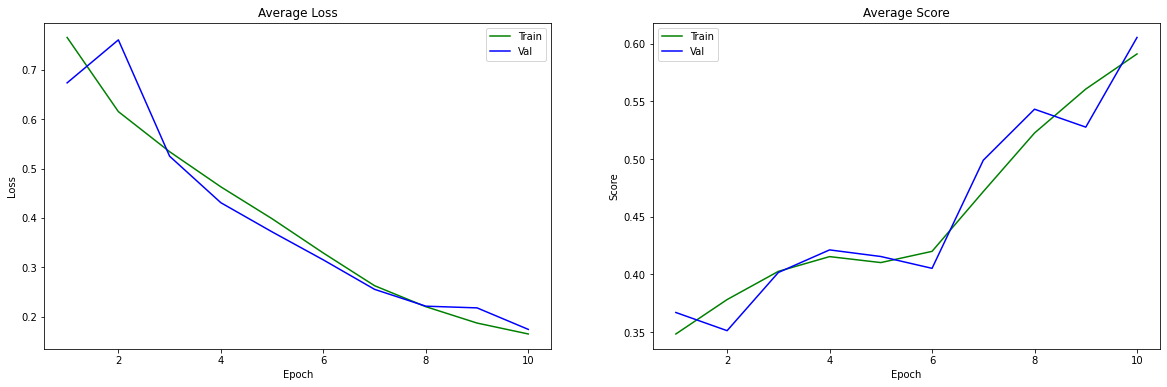

In [6]:
# === training with augmentation: ColorJitter ===

image_transform_with_augmentation = T.Compose([
    T.ColorJitter(brightness=0.25, contrast=0.25), 
    T.Resize((tH, tW)), 
    custom_transforms.BilateralFilter(sigma_color, sigma_space, diameter), 
    T.Normalize(mean, std)])

train_dataset_with_augmentation = dataset.MyDataset(
    X_train, Y_train, image_transform_with_augmentation, target_transform)
    
model = unet.UNet(out_channels=n_classes)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

results = training_and_testing.train_model(
    device, model, train_dataset_with_augmentation, batch_size, n_epochs, score_fn, loss_fn, optimizer, 
    lr_scheduler=None, evaluate=True, verbose=True)

training_and_testing.plot_training_results(results, plotsize=(20, 6))

Device: cuda.
--- Epoch 1/10 ---
average_train_loss: 0.723408670167298, average_train_score: 0.35406479239463806
average_val_loss: 0.6635595957438151, average_val_score: 0.36328840255737305
--- Epoch 2/10 ---
average_train_loss: 0.5891760462030047, average_train_score: 0.3803522288799286
average_val_loss: 0.5797129065271408, average_val_score: 0.3753809332847595
--- Epoch 3/10 ---
average_train_loss: 0.5087413919447494, average_train_score: 0.402165025472641
average_val_loss: 0.4962021131364126, average_val_score: 0.39366626739501953
--- Epoch 4/10 ---
average_train_loss: 0.44128453697574105, average_train_score: 0.40731269121170044
average_val_loss: 0.40540918187489583, average_val_score: 0.4247090518474579
--- Epoch 5/10 ---
average_train_loss: 0.38318060079531113, average_train_score: 0.4126318097114563
average_val_loss: 0.41250214264506385, average_val_score: 0.39705175161361694
--- Epoch 6/10 ---
average_train_loss: 0.3348932997283772, average_train_score: 0.42515045404434204
aver

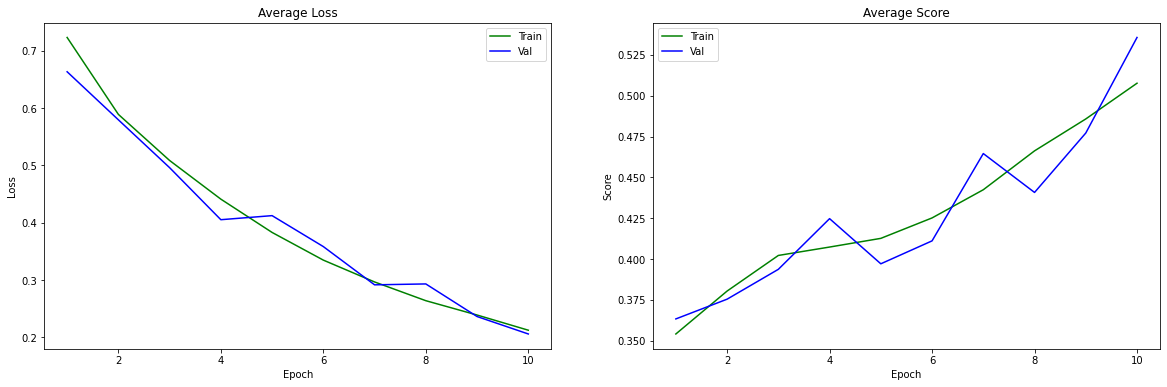

In [7]:
# === training with augmentation: horizontal_flip ===

image_transform_with_augmentation = T.Compose([
    horizontal_flip,
    T.Resize((tH, tW)), 
    custom_transforms.BilateralFilter(sigma_color, sigma_space, diameter), 
    T.Normalize(mean, std)])

target_transform_with_augmentation = T.Compose([
    horizontal_flip,
    T.Resize((tH, tW))])

train_dataset_with_augmentation = dataset.MyDataset(
    X_train, Y_train, image_transform_with_augmentation, target_transform_with_augmentation)
    
model = unet.UNet(out_channels=n_classes)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

results = training_and_testing.train_model(
    device, model, train_dataset_with_augmentation, batch_size, n_epochs, score_fn, loss_fn, optimizer, 
    lr_scheduler=None, evaluate=True, verbose=True)

training_and_testing.plot_training_results(results, plotsize=(20, 6))

Device: cuda.
--- Epoch 1/10 ---
average_train_loss: 0.7354816665336956, average_train_score: 0.3615697920322418
average_val_loss: 0.6788715512033493, average_val_score: 0.3794899880886078
--- Epoch 2/10 ---
average_train_loss: 0.5944856020629915, average_train_score: 0.3854421377182007
average_val_loss: 0.5486899623795162, average_val_score: 0.3912098705768585
--- Epoch 3/10 ---
average_train_loss: 0.5169091185613236, average_train_score: 0.4008455276489258
average_val_loss: 0.5428856313228607, average_val_score: 0.40573248267173767
--- Epoch 4/10 ---
average_train_loss: 0.4579453008127348, average_train_score: 0.41113877296447754
average_val_loss: 0.4607998648333171, average_val_score: 0.40752914547920227
--- Epoch 5/10 ---
average_train_loss: 0.38914856900516737, average_train_score: 0.42371127009391785
average_val_loss: 0.3880127625805991, average_val_score: 0.4001893401145935
--- Epoch 6/10 ---
average_train_loss: 0.32674170109281514, average_train_score: 0.45102831721305847
avera

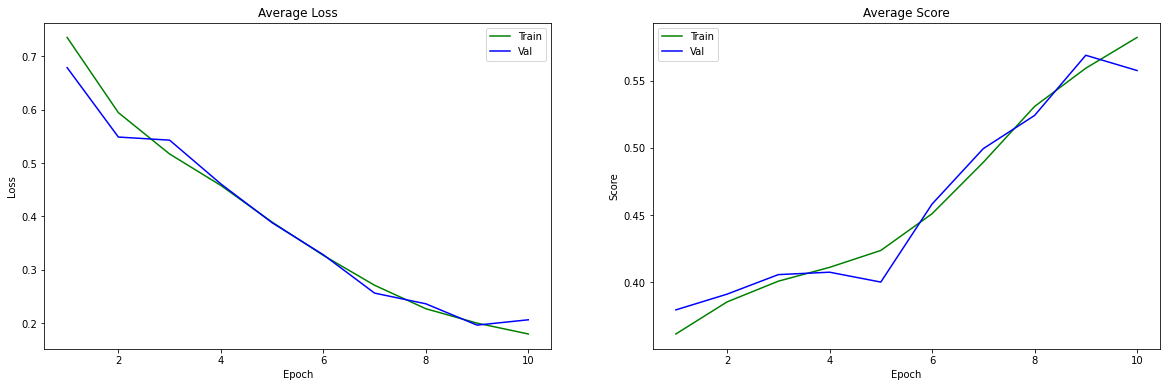

In [8]:
# === training with augmentation: center_crop ===

image_transform_with_augmentation = T.Compose([
    center_crop,
    T.Resize((tH, tW)), 
    custom_transforms.BilateralFilter(sigma_color, sigma_space, diameter), 
    T.Normalize(mean, std)])

target_transform_with_augmentation = T.Compose([
    center_crop,
    T.Resize((tH, tW))])

train_dataset_with_augmentation = dataset.MyDataset(
    X_train, Y_train, image_transform_with_augmentation, target_transform_with_augmentation)

model = unet.UNet(out_channels=n_classes)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

results = training_and_testing.train_model(
    device, model, train_dataset_with_augmentation, batch_size, n_epochs, score_fn, loss_fn, optimizer, 
    lr_scheduler=None, evaluate=True, verbose=True)

training_and_testing.plot_training_results(results, plotsize=(20, 6))